<img src="../images/logos/arm_logo.png" width=500 alt="ARM Logo"></img>

# Solutions: Snowfall Retrievals from SAIL X-Band Radar

In [1]:
%env PYTHONWARNINGS=ignore

env: PYTHONWARNINGS=ignore


In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)

import glob
import os
import datetime

import numpy as np
import matplotlib.pyplot as plt
import pyart
import act
import xarray as xr
from matplotlib.dates import DateFormatter
from pathlib import Path

from metpy.plots import USCOUNTIES
from dask.distributed import Client, LocalCluster

import cartopy.crs as ccrs
import cartopy.feature as cfeature

import xwrf


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed


## Setup Helper Functions
We setup helper functions to calculate the snowfall retrieval, using following notation:

$Z = A*S ^ {B}$

Where:
- Z = Reflectivity in dBZ
- A = Coefficient applied to Z-S Relationship (not in the exponent)
- S = Liquid snowfall rate
- B = Coefficient applied to Z-S Relationship (in the exponent)

We also need to apply a snow water equivalent ratio (`swe`) to convert from liquid to snow (ex. 8 inches of snow --> 1 inch of rain would be 8.0).

This equation now becomes:

$Z = swe*A*S ^ {B}$

Solving for S, we get:

$S = swe * (\frac{z}{a})^{1/B}$

Where z is reflectivity in units of dB ($z =10^{Z/10}$)

## List the Available Files
We will use files on the Oak Ridge Laboratory Computing Facility (ORLCF), within the shared SAIL directory `/gpfs/wolf/atm124/proj-shared/sail`.


In [4]:
file_list = sorted(glob.glob("/data/project/ARM_Summer_School_2024_Data/sail/radar/*"))

In [5]:
file_list[0:10]

['/data/project/ARM_Summer_School_2024_Data/sail/radar/gucxprecipradarcmacS2.c1.20220310.000206.nc',
 '/data/project/ARM_Summer_School_2024_Data/sail/radar/gucxprecipradarcmacS2.c1.20220310.000726.nc',
 '/data/project/ARM_Summer_School_2024_Data/sail/radar/gucxprecipradarcmacS2.c1.20220310.001246.nc',
 '/data/project/ARM_Summer_School_2024_Data/sail/radar/gucxprecipradarcmacS2.c1.20220310.001806.nc',
 '/data/project/ARM_Summer_School_2024_Data/sail/radar/gucxprecipradarcmacS2.c1.20220310.002326.nc',
 '/data/project/ARM_Summer_School_2024_Data/sail/radar/gucxprecipradarcmacS2.c1.20220310.002846.nc',
 '/data/project/ARM_Summer_School_2024_Data/sail/radar/gucxprecipradarcmacS2.c1.20220310.003406.nc',
 '/data/project/ARM_Summer_School_2024_Data/sail/radar/gucxprecipradarcmacS2.c1.20220310.003926.nc',
 '/data/project/ARM_Summer_School_2024_Data/sail/radar/gucxprecipradarcmacS2.c1.20220310.004446.nc',
 '/data/project/ARM_Summer_School_2024_Data/sail/radar/gucxprecipradarcmacS2.c1.20220310.00

<div class="admonition alert alert-success">
    <p class="admonition-title" style="font-weight:bold">Question 1 - Easy</p>
    Using material presented this week, apply one of the above relationships to SAIL X-Band radar file and display
</div>

## Read Data + Apply Snowfall Retrieval

In [3]:
def snow_rate(radar, swe_ratio, A, B, key="snow_z"):
    """
    Snow rate applied to a pyart.Radar object
    
    Takes a given Snow Water Equivilent ratio (swe_ratio), A and B value
    for the Z-S relationship and creates a radar field similar to DBZ
    showing the radar estimated snowfall rate in mm/hr. Then the given
    SWE_ratio, A and B are stored in the radar metadata for later 
    reference.

    """
    # Setting up for Z-S relationship:
    snow_z = radar.fields['corrected_reflectivity']['data'].copy()
    # Convert it from dB to linear units
    z_lin = 10.0**(radar.fields['corrected_reflectivity']['data']/10.)
    # Apply the Z-S relation.
    snow_z = swe_ratio * (z_lin/A)**(1./B)
    # Add the field back to the radar. Use reflectivity as a template
    radar.add_field_like('corrected_reflectivity', key,  snow_z,
                         replace_existing=True)
    # Update units and metadata
    radar.fields[key]['units'] = 'mm/h'
    radar.fields[key]['standard_name'] = 'snowfall_rate'
    radar.fields[key]['long_name'] = 'user_defined_snowfall_rate_from_z'
    radar.fields[key]['valid_min'] = 0
    radar.fields[key]['valid_max'] = 500
    radar.fields[key]['swe_ratio'] = swe_ratio
    radar.fields[key]['A'] = A
    radar.fields[key]['B'] = B
    return radar

In [6]:
radar = pyart.io.read(file_list[0])

In [7]:
radar = snow_rate(radar, 8.5, 67, 1.28, key="snow_z_new")

/opt/conda/lib/python3.11/site-packages/numpy/ma/core.py:6980: RuntimeWarning: overflow encountered in power
  result = np.where(m, fa, umath.power(fa, fb)).view(basetype)


In [8]:
# Check to see if the snowfall retrieval was applied
list(radar.fields.keys())

['DBZ',
 'VEL',
 'WIDTH',
 'ZDR',
 'PHIDP',
 'RHOHV',
 'NCP',
 'DBZhv',
 'cbb_flag',
 'sounding_temperature',
 'height',
 'signal_to_noise_ratio',
 'velocity_texture',
 'gate_id',
 'simulated_velocity',
 'corrected_velocity',
 'unfolded_differential_phase',
 'corrected_differential_phase',
 'filtered_corrected_differential_phase',
 'corrected_specific_diff_phase',
 'filtered_corrected_specific_diff_phase',
 'corrected_differential_reflectivity',
 'corrected_reflectivity',
 'height_over_iso0',
 'specific_attenuation',
 'path_integrated_attenuation',
 'specific_differential_attenuation',
 'path_integrated_differential_attenuation',
 'rain_rate_A',
 'snow_rate_ws2012',
 'snow_rate_ws88diw',
 'snow_rate_m2009_1',
 'snow_rate_m2009_2',
 'snow_z_new']

## Display Snowfall Retrieval

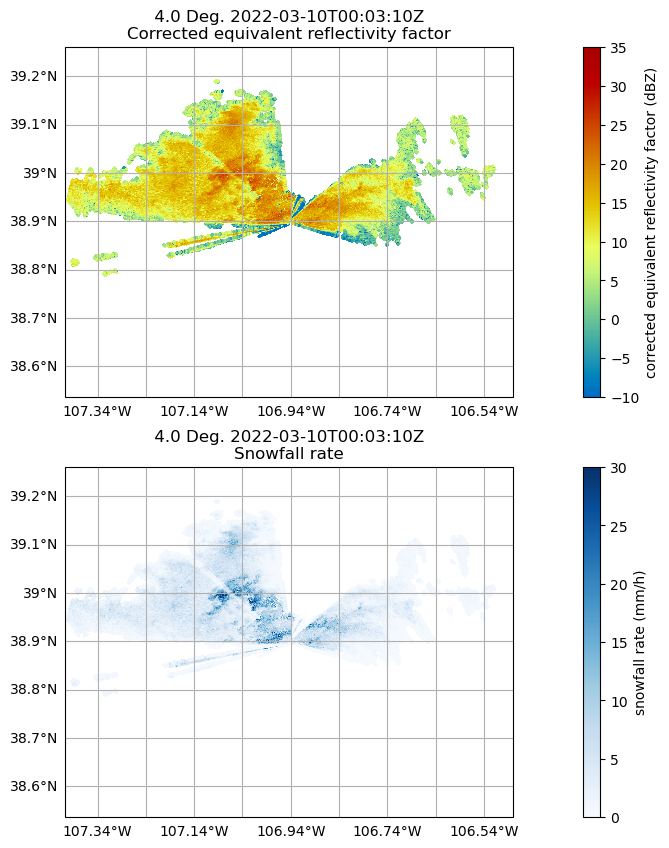

In [9]:
# Create the Py-ART display object
display = pyart.graph.RadarMapDisplay(radar)
# Define the matplotlib figure
fig = plt.figure(figsize=(18,10))

# Extract the latitude and longitude of the radar and use it for the center of the map
lat_center = round(radar.latitude['data'][0], 2)
lon_center = round(radar.longitude['data'][0], 2)

# Set the projection - in this case, we use a general PlateCarree projection
projection = ccrs.PlateCarree()

# Determine the ticks
lat_ticks = np.arange(lat_center-0.5, lat_center+1, .1)
lon_ticks = np.arange(lon_center-0.5, lon_center+1, .1)

# Define a subplot for the reflectivity field
ax1 = plt.subplot(211, projection=projection)
display.plot_ppi_map("corrected_reflectivity", 
                     2, 
                     resolution='10m', 
                     ax=ax1, 
                     lat_lines=lat_ticks, 
                     lon_lines=lon_ticks,
                     vmin=-10,
                     vmax=35)

# Define a subplot for the snowfall retrieval
ax2 = plt.subplot(212, projection=projection)
display.plot_ppi_map("snow_z_new", 
                     2, 
                     resolution='10m', 
                     ax=ax2, 
                     lat_lines=lat_ticks, 
                     lon_lines=lon_ticks,
                     vmin=0,
                     vmax=30,
                     cmap='Blues')

<div class="admonition alert alert-warning">
    <p class="admonition-title" style="font-weight:bold">Question 2 - Intermediate</p>
    Using the above methodology, calculate the snowfall accumulation for an hour (or day) 
</div>

## Gridded Observations Using Nearest Neighbor Interpolation

In [10]:
def compute_number_of_points(extent, resolution):
    """
    Create a helper function to determine number of points
    """
    return int((extent[1] - extent[0])/resolution)

# Grid extents in meters
z_grid_limits = (500.,5_000.)
y_grid_limits = (-20_000.,20_000.)
x_grid_limits = (-20_000.,20_000.)

# Grid resolution in meters
grid_resolution = 250

# Determine number of points with our desired input
x_grid_points = compute_number_of_points(x_grid_limits, grid_resolution)
y_grid_points = compute_number_of_points(y_grid_limits, grid_resolution)
z_grid_points = compute_number_of_points(z_grid_limits, grid_resolution)

print(z_grid_points,
      y_grid_points,
      x_grid_points)

18 160 160


In [11]:
# Call Py-ART gridding module, with our grid specifications
grid = pyart.map.grid_from_radars(radar,
                                  grid_shape=(z_grid_points,
                                              y_grid_points,
                                              x_grid_points),
                                  grid_limits=(z_grid_limits,
                                               y_grid_limits,
                                               x_grid_limits),
                                  method='nearest'
                                 )

In [12]:
ds = grid.to_xarray()

In [13]:
ds

<xarray.Dataset> Size: 122MB
Dimensions:                                   (time: 1, z: 18, y: 160, x: 160)
Coordinates:
  * time                                      (time) object 8B 2022-03-10 00:...
  * z                                         (z) float64 144B 500.0 ... 5e+03
    lat                                       (y, x) float64 205kB 38.72 ... ...
    lon                                       (y, x) float64 205kB -107.2 ......
  * y                                         (y) float64 1kB -2e+04 ... 2e+04
  * x                                         (x) float64 1kB -2e+04 ... 2e+04
Data variables: (12/35)
    NCP                                       (time, z, y, x) float64 4MB 0.1...
    snow_rate_m2009_1                         (time, z, y, x) float64 4MB nan...
    specific_differential_attenuation         (time, z, y, x) float64 4MB nan...
    filtered_corrected_specific_diff_phase    (time, z, y, x) float64 4MB 0.0...
    path_integrated_differential_attenuation  (time, z, y, x) float64 4MB nan...
    filtered_corrected_differential_phase     (time, z, y, x) float64 4MB 0.0...
    ...                                        ...
    corrected_differential_reflectivity       (time, z, y, x) float64 4MB nan...
    simulated_velocity                        (time, z, y, x) float64 4MB -2....
    rain_rate_A                               (time, z, y, x) float64 4MB nan...
    sounding_temperature                      (time, z, y, x) float32 2MB -13...
    signal_to_noise_ratio                     (time, z, y, x) float64 4MB -1....
    ROI                                       (time, z, y, x) float32 2MB 493...

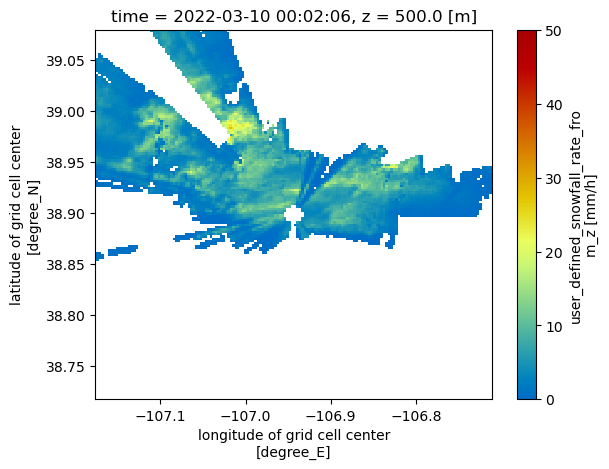

In [14]:
ds.snow_z_new.isel(z=0).plot(x='lon',
                             y='lat',
                             vmin=0, 
                             vmax=50,
                             cmap='pyart_HomeyerRainbow')

### Determine the Lowest Height in Each Column
We plotted the lowest level (500 m) in the plot above. It would be **more helpful** to have data from the lowest data point (lowest z) in each column (across time, latitude, and longitude)

We start first by creating a new field in our dataset, `height_expanded`, which is a four-dimensional (time, z, x, y) vertical coordinate, with nan values where we have missing snow rate values.

In [15]:
ds["height_expanded"] = (ds.z * (ds.snow_z_new/ds.snow_z_new)).fillna(10_000)

Next, we find the index of the lowest value in this column, using the `.argmin` method, looking over the column (z)

In [16]:
min_index = ds.height_expanded.argmin(dim='z',
                                      skipna=True)

Here is a plot of the lowest value height in the column for our domain:

**Notice how some values are the top of the column - 5000 m, whereas some of the values are close lowest vertical level, 500 m

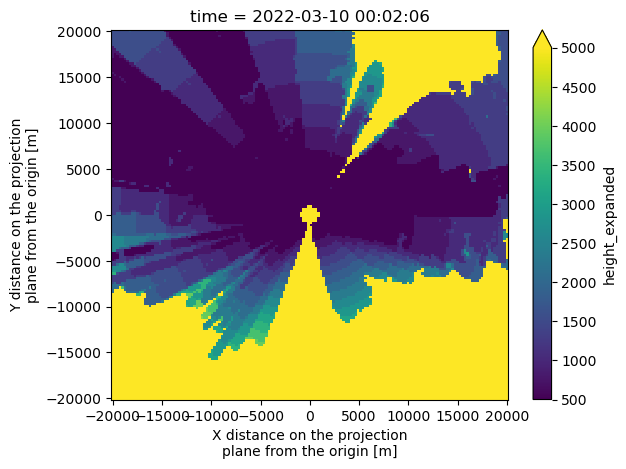

In [17]:
ds.height_expanded.isel(z=min_index).plot(vmin=500,
                                          vmax=5000);

### Apply this to our snow fields
We first check for snow fields in our dataset, by using the following list comprehension line:

In [18]:
snow_fields = [var for var in list(ds.variables) if "snow" in var]
snow_fields

['snow_rate_m2009_1',
 'snow_rate_m2009_2',
 'snow_rate_ws88diw',
 'snow_z_new',
 'snow_rate_ws2012']

In [19]:
subset_ds = ds[snow_fields].isel(z=min_index)

### Visualize our closest-to-ground snow value
Now that we have the lowest vertical level in each column, let's plot our revised maps, which only have dimensions:
- time
- latitude
- longitude

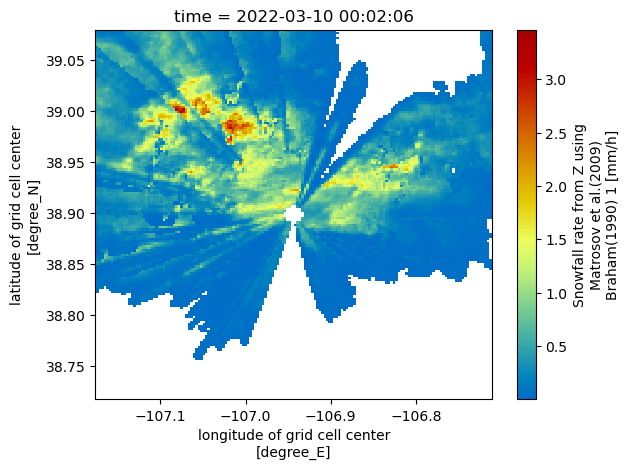

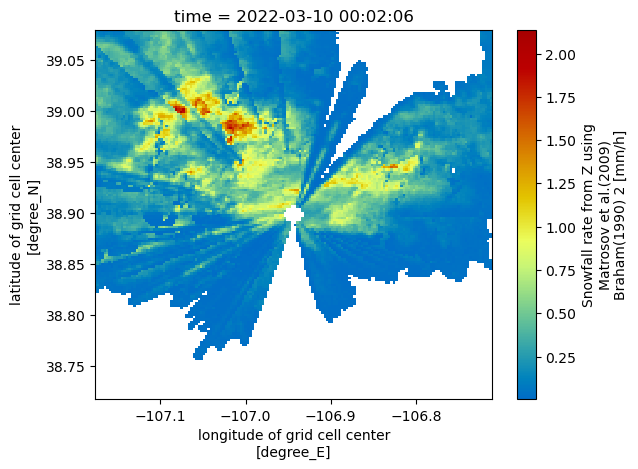

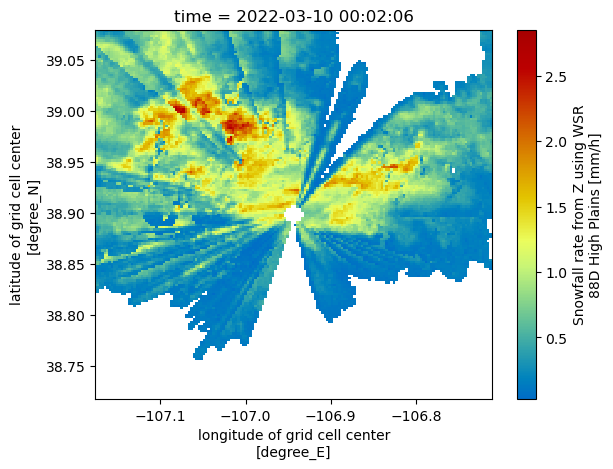

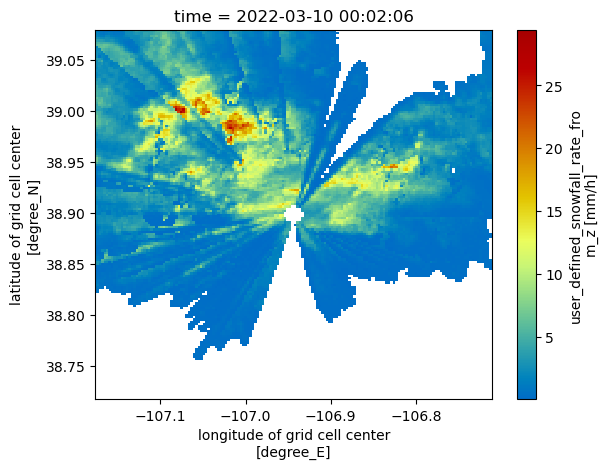

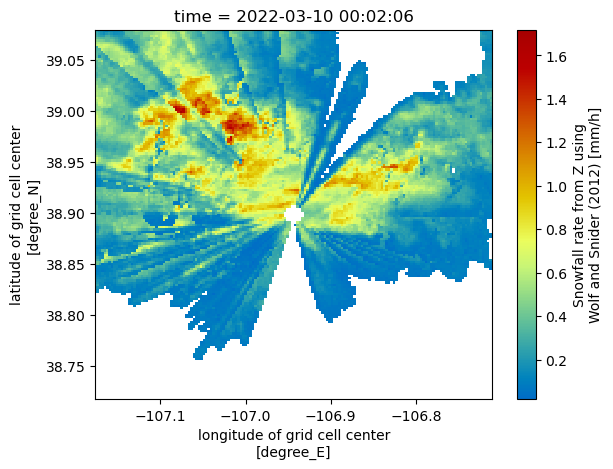

In [20]:
for snow_field in snow_fields:
    subset_ds[snow_field].plot(x='lon',
                               y='lat',
                               cmap='pyart_HomeyerRainbow')
    plt.show()
    plt.close()

## Calculate Daily Accumulation of Snowfall

In [21]:
def grid_radar(file,
               x_grid_limits=(-20_000.,20_000.),
               y_grid_limits=(-20_000.,20_000.),
               z_grid_limits = (500.,5_000.),
               grid_resolution = 250,
               
               ):
    """
    Grid the radar using some provided parameters
    """
    try:
        radar = pyart.io.read(file)
    except:
        radar = None

    if radar:
        x_grid_points = compute_number_of_points(x_grid_limits, grid_resolution)
        y_grid_points = compute_number_of_points(y_grid_limits, grid_resolution)
        z_grid_points = compute_number_of_points(z_grid_limits, grid_resolution)
    
        grid = pyart.map.grid_from_radars(radar,
                                          grid_shape=(z_grid_points,
                                                      y_grid_points,
                                                      x_grid_points),
                                          grid_limits=(z_grid_limits,
                                                       y_grid_limits,
                                                       x_grid_limits),
                                          method='nearest'
                                         )
        grid_out = grid.to_xarray()
        del radar
    else:
        grid_out = None
        
    return grid_out

def subset_lowest_vertical_level(ds, additional_fields=["corrected_reflectivity"]):
    """
    Filter the dataset based on the lowest vertical level
    """
    snow_fields = [var for var in list(ds.variables) if "snow" in var] + additional_fields
    
    # Create a new 4-d height field
    ds["height_expanded"] = (ds.z * (ds[snow_fields[0]]/ds[snow_fields[0]])).fillna(5_000)
    
    # Find the minimum height index
    min_index = ds.height_expanded.argmin(dim='z',
                                          skipna=True)
    
    # Subset our snow fields based on this new index
    subset_ds = ds[snow_fields].isel(z=min_index)
    
    return subset_ds

In [22]:
def process_squire(file):
    """ Script to process SQUIRE """
    ds = grid_radar(file)
    if ds:
        out_ds = subset_lowest_vertical_level(ds)
    
        # Create an output path
        ##out_path = f"./{Path(file).stem}.gridded.nc"
        ##out_ds.to_netcdf(out_path)

        # free up memory
        del ds
    else:
        out_ds = None
    
    return out_ds 

## Spin up Dask Cluster and Process SQUIRE

In [23]:
%%time
## Start up a Dask Cluster
cluster = LocalCluster()
with Client(cluster) as client:
    future = client.map(process_squire, file_list)
    my_data = client.gather(future)

ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed
ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed
ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed
ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed
2024-05-22 18:33:11,321 - distributed.nanny - WARNING - Restarting worker
2024-05-22 18:33:11,377 - distributed.nanny - WARNING - Restarting worker
2024-05-22 18:33:11,383 - distributed.nanny - WARNING - Restarting worker
ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed
ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed
ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed
2024-05-22 18:33:13,939 - distributed.nanny - WARNING - Restarting worker
ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed
HDF5-DIAG: Error detected in HDF5 (1.14.3) thread 1:
  #000: H5D.c line 

CPU times: user 9.7 s, sys: 4.61 s, total: 14.3 s
Wall time: 9min 37s


In [24]:
# Concatenate all extracted columns across time dimension to form daily timeseries
ds = xr.concat([data for data in my_data if data], dim='time')

## Calculate Daily Accumulation

In [25]:
new_ds = ds.resample(time='h').sum()

In [26]:
new_ds

<xarray.Dataset> Size: 25MB
Dimensions:                 (time: 24, y: 160, x: 160)
Coordinates:
    lat                     (y, x) float64 205kB 38.72 38.72 ... 39.08 39.08
    lon                     (y, x) float64 205kB -107.2 -107.2 ... -106.7 -106.7
  * y                       (y) float64 1kB -2e+04 -1.975e+04 ... 2e+04
  * x                       (x) float64 1kB -2e+04 -1.975e+04 ... 2e+04
  * time                    (time) object 192B 2022-03-10 00:00:00 ... 2022-0...
Data variables:
    snow_rate_ws2012        (time, y, x) float64 5MB 0.0 0.0 0.0 ... 0.0 0.0 0.0
    snow_rate_m2009_1       (time, y, x) float64 5MB 0.0 0.0 0.0 ... 0.0 0.0 0.0
    snow_rate_m2009_2       (time, y, x) float64 5MB 0.0 0.0 0.0 ... 0.0 0.0 0.0
    snow_rate_ws88diw       (time, y, x) float64 5MB 0.0 0.0 0.0 ... 0.0 0.0 0.0
    corrected_reflectivity  (time, y, x) float64 5MB 0.0 0.0 0.0 ... 0.0 0.0 0.0

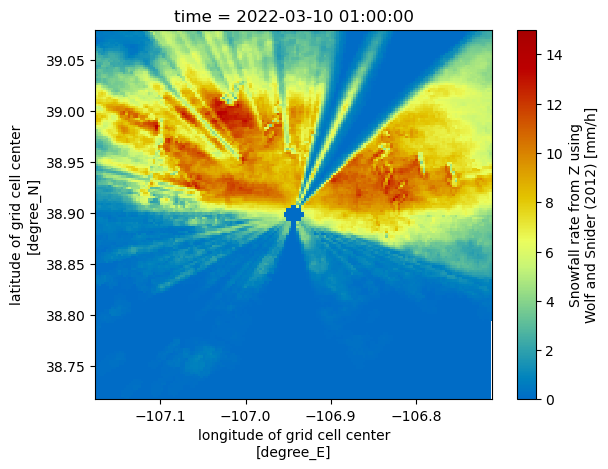

In [27]:
new_ds['snow_rate_ws2012'].isel(time=1).plot(x='lon', y='lat', cmap='pyart_HomeyerRainbow', vmin=0, vmax=15)

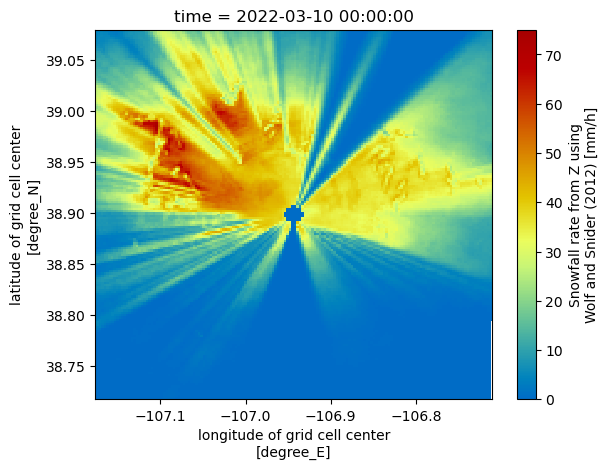

In [28]:
new_ds['snow_rate_ws2012'].resample(time='D').sum().plot(x='lon', y='lat', cmap='pyart_HomeyerRainbow')

<div class="admonition alert alert-danger">
    <p class="admonition-title" style="font-weight:bold">Question 3 - Hard</p>
    Compare this hourly (or daily) accumulation to WRF output for the same day

## Compare against WRF Run

In [29]:
files = sorted(glob.glob("/data/project/ARM_Summer_School_2024_Data/sail/wrf/*"))

In [30]:
first_ds = xr.open_dataset(files[0]).xwrf.postprocess().squeeze()
last_ds = xr.open_dataset(files[-1]).xwrf.postprocess().squeeze()

In [31]:
difference = last_ds["SNOW"] - first_ds["SNOW"]

Text(0.5, 1.0, '24 Hour Difference in \n Snow Water Liquid Equivalent \n 10 March to 11 March 2023')

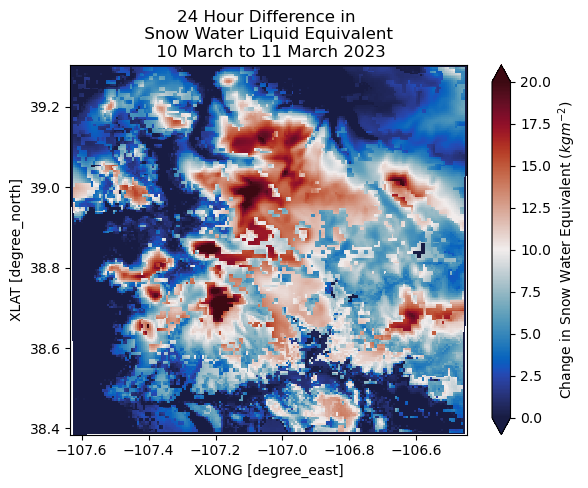

In [33]:
difference.plot(x='XLONG',
                y='XLAT',
                cbar_kwargs={'label': "Change in Snow Water Equivalent ($kgm^{-2}$)"},
                vmin=0,
                vmax=20,
                cmap="pyart_balance")
plt.title("24 Hour Difference in \n Snow Water Liquid Equivalent \n 10 March to 11 March 2023")

(38.7, 39.1)

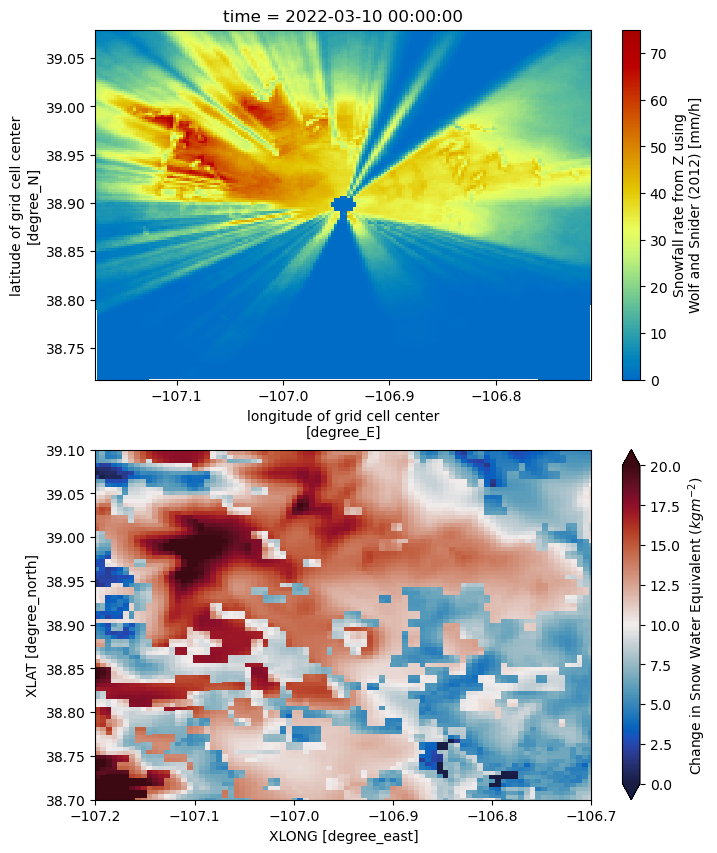

In [34]:
fig, axarr = plt.subplots(2, 1, figsize=[8, 10])

new_ds['snow_rate_ws2012'].resample(time='D').sum().plot(x='lon', 
                                                         y='lat', 
                                                         cmap='pyart_HomeyerRainbow',
                                                         ax=axarr[0])
difference.plot(x='XLONG',
                y='XLAT',
                cbar_kwargs={'label': "Change in Snow Water Equivalent ($kgm^{-2}$)"},
                vmin=0,
                vmax=20,
                cmap="pyart_balance",
                ax=axarr[1])
#axarr[0].set_xlim([-107.7, -106.5])
axarr[1].set_xlim([-107.2, -106.7])
axarr[1].set_ylim([38.7, 39.1])